In [1]:
from underlying import Underlying, NonTradedUnderlying
from option import Option, Vanilla, Vanilla_on_NonTraded
from trader import Trader

import matplotlib.pyplot as plt
import seaborn as sb
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [2]:
mu_nt = 0.1
mu_t = 0.1
sigma_nt =  0.1
sigma_t =  0.1
X0_nt = 100
X0_t = 100
rho = 0.999999
r = 0
T = 1
repeat = 200
values_per_year = 250

K = 100

In [3]:
underlying_t = Underlying(mu_t, sigma_t, r, values_per_year)

In [4]:
underlying_nt = NonTradedUnderlying(mu_nt, sigma_nt, underlying_t, rho)

In [5]:
sims_t, sims_nt = underlying_nt.simulate_together_P(repeat, T)
B_t, reality_t = sims_t
B_nt, reality_nt = sims_nt

<AxesSubplot:>

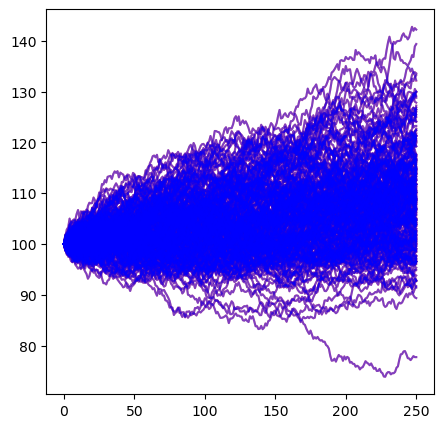

In [6]:
fig, axs = plt.subplots(1,1, figsize=(5,5))
(X0_nt*reality_nt).T.plot(legend = False, color = 'red', alpha = 0.5, ax = axs)
(X0_t*reality_t).T.plot(legend = False, color = 'blue', alpha = 0.5, ax = axs)

In [7]:
def payoff_special(option_nt, X_t, X_nt, m):   
    X0_t, X0_nt = X_t.iloc[0,0], X_nt.iloc[0,0]
    mu_t, sigma_t = option_nt.underlying_nt.underlying_t.mu, option_nt.underlying_nt.underlying_t.sigma
    mu_nt, sigma_nt = option_nt.underlying_nt.mu, option_nt.underlying_nt.sigma
    B_T = (np.log(X_t.iloc[:,-1] / X0_t) - (mu_t - 0.5 * sigma_t**2)*option_nt.T) / sigma_t
    r = option_nt.underlying_nt.r
    rho = option_nt.underlying_nt.rho
    dP_dQ = np.exp((mu_t - r) * B_T / sigma_t + (0.5 * option_nt.T * ((mu_t - r) / sigma_t) ** 2))
    a = 1
    b = 2 * sigma_nt ** 2 * option_nt.T * (1 - rho ** 2) - 2 * np.log(X0_nt) - 2 * mu_nt * option_nt.T + sigma_nt ** 2 * option_nt.T - 2 * rho * sigma_nt * B_T
    c = np.log(m / dP_dQ  * sigma_nt * np.sqrt(2 * np.pi * option_nt.T * (1 - rho ** 2))) * (2 * sigma_nt ** 2 * option_nt.T * (1 - rho ** 2 )) + (-np.log(X0_nt) - mu_nt * option_nt.T + sigma_nt ** 2 * option_nt.T * 0.5 - rho * sigma_nt * B_T) ** 2 
    delta = b**2 - 4 * a * c
    print((delta > 0).sum())
    sign = (2 * option_nt.call * 1 - 1)
    x = sign * np.exp(( -b + sign * np.sqrt(abs(delta))) / (2 * a )) - sign * option_nt.K
    cdf_x = norm.cdf((np.log((option_nt.K + x) / X0_nt) - mu_nt * option_nt.T + 0.5 * sigma_nt ** 2 * option_nt.T - sigma_nt * rho * B_T)/ (sigma_nt * np.sqrt(option_nt.T * (1 - rho ** 2))))
    cdf_delta = norm.cdf((np.log((option_nt.K + 0.01) / X0_nt) - mu_nt * option_nt.T + 0.5 * sigma_nt ** 2 * option_nt.T - sigma_nt * rho * B_T)/ (sigma_nt * np.sqrt(option_nt.T * (1 - rho ** 2))))
    diff_x = dP_dQ * (cdf_x if option_nt.call else (1 - cdf_x)) - m * x
    diff_delta = dP_dQ * (cdf_delta if option_nt.call else (1 - cdf_delta)) - m * 0.01
    return x * (x >= 0) * (diff_delta <= diff_x) * (delta >= 0)

In [8]:
call_nt = Vanilla_on_NonTraded(underlying_nt, K, T, True)

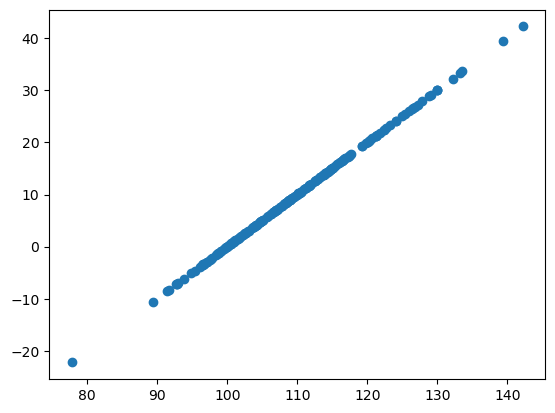

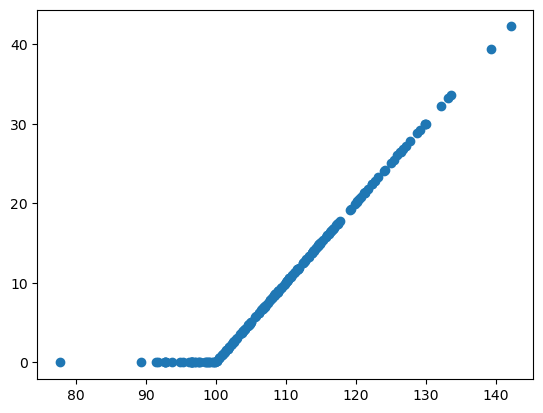

58


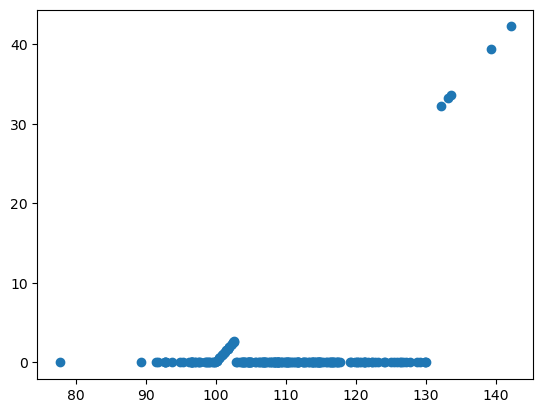

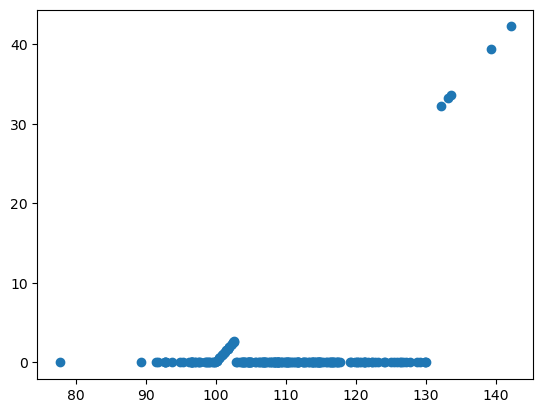

In [9]:
plt.scatter((X0_t * reality_t).iloc[:,-1], call_nt.payoff_special(X0_t * reality_t, X0_nt * reality_nt, 0.3))

In [10]:
K = 120

In [11]:
put_nt = Vanilla_on_NonTraded(underlying_nt, K, T, False)

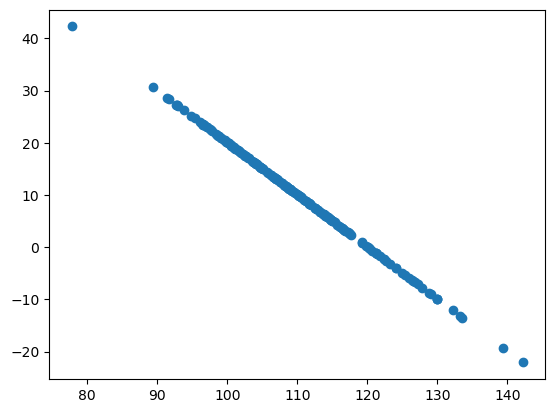

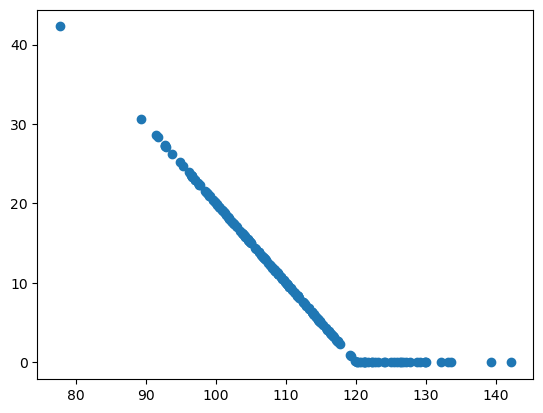

94


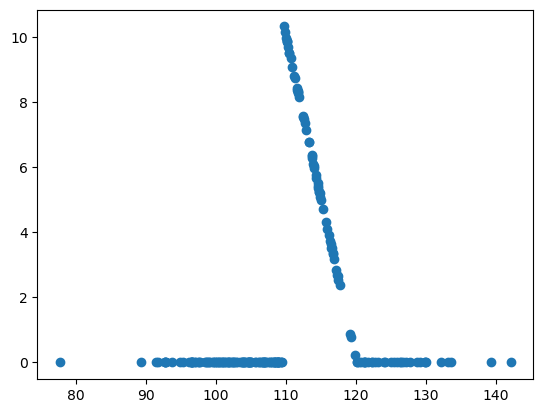

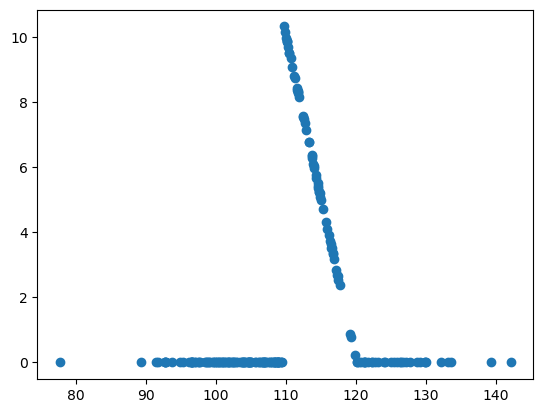

In [12]:
plt.scatter((X0_t * reality_t).iloc[:,-1], put_nt.payoff_special(X0_t * reality_t, X0_nt * reality_nt, 0.15))